As per the [Wolrd Health Organization](https://www.who.int/health-topics/coronavirus), Coron Viruses (CoV) are a family of viruses that cause illnesses ranging from common to sever diseases. The Novel CoronoVirus(nCoV or COVID-19) is a new strain that had not been previously identified in the humans. The World Health Organization first reported the outbreak of Corona Virus Disease (COVID-19) on Decemeber 31, 2019. You can follow the updates on COVID-19 outbreak from [WHO](https://www.who.int/emergencies/diseases/novel-coronavirus-2019).

Today we'll analyze the COVID-19 outbreak around the world. How is the outbreak spreading, and how are the infected people recovering around the world. 

## Outbreak analysis
Let's start with the latest stats on the COVID-19 outbreak.

In [1]:
# Imports
# Visualization
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots


# hide warnings
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
outbreak = pd.read_csv('../data/covid_19_data.csv',parse_dates=['ObservationDate'])

# Data cleaning
# Rename the columns for easy use
outbreak = outbreak.rename(columns={'Country/Region':'Country','ObservationDate':'Date','Province/State':'State'})

# Combine the counts from China.
outbreak.Country = outbreak.Country.str.replace('Mainland China','China')

outbreakOverall = outbreak.groupby('Date')['Confirmed','Deaths','Recovered'].sum()
outbreakOverall.reset_index(inplace=True)
outbreakOverall['Active'] = outbreakOverall.Confirmed - outbreakOverall.Deaths - outbreakOverall.Recovered

latest = outbreakOverall[outbreakOverall.Date == max(outbreakOverall.Date)]
latest.style.background_gradient(cmap='Reds',axis=1)

,Date,Confirmed,Deaths,Recovered,Active
68,2020-03-30 00:00:00,782365,37582,164566,580217


Let's take a look at the overall trend for the spread of COVID-19 over the days.

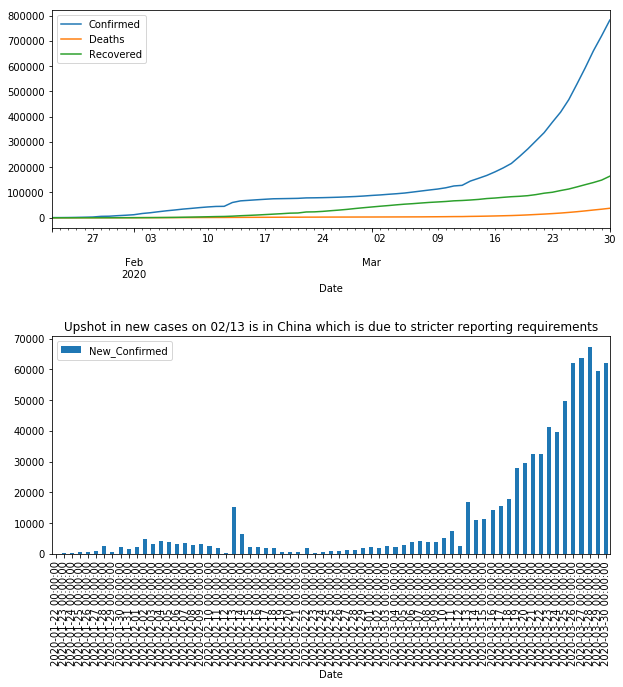

In [2]:
# Compute the first degree of differences
outbreakOverall['New_Confirmed'] = outbreakOverall.Confirmed.diff()
outbreakOverall['New_Recovered'] = outbreakOverall.Recovered.diff()
outbreakOverall['New_Deaths']    = outbreakOverall.Deaths.diff()

# Let's get the axes
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

# Plot the charts
# ax1 : Confirmed cases, deaths and recovered cases by Date
outbreakOverall.plot(x='Date',y=['Confirmed','Deaths','Recovered'],kind='line', ax=ax1)

# ax2 : New Confirmations per day
outbreakOverall.plot(x='Date',y=['New_Confirmed'],kind='bar', ax=ax2,
                     title='Upshot in new cases on 02/13 is in China which is due to stricter reporting requirements')

plt.subplots_adjust(hspace = 0.5)

As can be seen from the above chart, the disease started spreading fast since 1st Feb 2020. 
* There was a huge burst of disease on Feb 13th. As per the news reports, the jump in new cases—more than 14,800 on Feb 13th in China at the epicenter of the outbreak—is due to a change in the criteria for counting diagnoses of the virus. For more information, please read the article [Hubei cases classification](https://time.com/5783401/covid19-hubei-cases-classification/)
* There is a second wave of exponential increase in early May. 

On the brighter side, the infected people also started recovering at a fast rate since mid Feb. 


# Number of countries infected over time. 
Now, Let's try visualize the number of countries impacted over the time. 

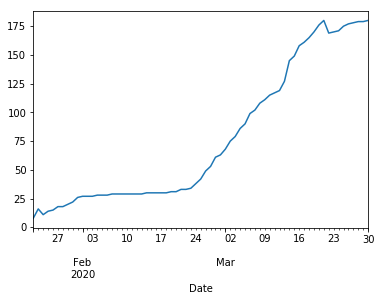

In [3]:
countriesOverTime = outbreak.groupby('Date').Country.nunique()
countriesOverTime.plot()

The number of countries impacted grew severly since Feb 24th. This could probably explain the exponential second wave of confirmed cases.

Now, let's visualize the global outbreak of COVID-19 by global map view.

In [4]:
outbreakByCountry = outbreak.groupby(['Date', 'Country'])['Confirmed', 'Deaths', 'Recovered'].sum()
outbreakByCountry.reset_index(inplace=True)

outbreakByCountry['DateStr'] = outbreakByCountry['Date'].dt.strftime('%m/%d/%Y')
outbreakByCountry['size'] = outbreakByCountry.Confirmed.pow(0.3)

fig = px.scatter_geo(outbreakByCountry, locations="Country", locationmode='country names', 
                     color="Confirmed", size='size', hover_name="Country",hover_data=['Confirmed','Deaths'],
                     range_color= [0, max(outbreakByCountry['Confirmed'])], 
                     projection="natural earth", animation_frame="DateStr", 
                     title='Spread over time')
fig.update(layout_coloraxis_showscale=False)
fig.show()

Let's visualize the number of deaths due to COVID-19 around the world over the time.

In [5]:
outbreakByCountry['DeathsSize'] = outbreakByCountry.Deaths.pow(0.5)
fig = px.scatter_geo(outbreakByCountry, locations="Country", locationmode='country names', 
                     size='DeathsSize', hover_name="Country", hover_data=['Deaths'],
                     projection="natural earth", animation_frame="DateStr",
                     color_continuous_scale='red',
                     # color_discrete_map='red',
                     title='Deaths over time')
fig.update(layout_coloraxis_showscale=False)
fig.show()

Let's look at top countries with severe outbreak of COVID-19 and the countries next in line due to proximity to affected contries and high count of confirmed cases.

In [6]:
latestByCountries = outbreakByCountry[outbreakByCountry.Date == max(outbreakByCountry.Date)]
latestByCountries.sort_values('Confirmed',ascending=False)[['Date','Country','Confirmed','Deaths','Recovered']].head(20).style.background_gradient(cmap='Reds')

,Date,Country,Confirmed,Deaths,Recovered
5321,2020-03-30 00:00:00,US,161807,2978,5644
5235,2020-03-30 00:00:00,Italy,101739,11591,14620
5305,2020-03-30 00:00:00,Spain,87956,7716,16780
5187,2020-03-30 00:00:00,China,81478,3304,75790
5215,2020-03-30 00:00:00,Germany,66885,645,13500
5211,2020-03-30 00:00:00,France,45170,3030,7964
5231,2020-03-30 00:00:00,Iran,41495,2757,13911
5320,2020-03-30 00:00:00,UK,22453,1411,171
5310,2020-03-30 00:00:00,Switzerland,15922,359,1823
5168,2020-03-30 00:00:00,Belgium,11899,513,1527


* China and S.Korea contained the spread and have stopped the growth.
* Spain, Germany, and Iran have crossed 20K confirmed cases and are growing. 
* France and US are trailing behind with over 15K confirmed cases and are rapidly growing since 3/15.
* Switzerland, UK, Netherlands, Belgium, and Austria are below 10K but are growing faster since 3/17.
* Portugal, Brazil, and Turkey while still under 1K confirmed cases have shown faster trend since 3/17.

# Top 20 countries

In [7]:
fig = px.bar(latestByCountries.sort_values('Confirmed',ascending=False).head(20).sort_values('Confirmed',ascending=True)
            ,x='Confirmed',y='Country', title='Top 20 countries by confirmed cases',text='Confirmed'
            ,orientation='h')
fig.update_traces(marker_color='#084177', opacity=0.8, textposition='outside')
fig.show()

In [8]:
fig = px.bar(latestByCountries.sort_values('Deaths',ascending=False).head(20).sort_values('Deaths',ascending=True)
            ,x='Deaths',y='Country', title='Top 20 countries by deaths', text='Deaths'
            ,orientation='h')
fig.update_traces(marker_color='Red', opacity=0.8, textposition='outside')
fig.show()

Now let's compare the outbreak in top 10 countries.

In [9]:
topCountries = latestByCountries.sort_values('Confirmed',ascending=False).Country.head(10).tolist()
outBreakForTopCountries=outbreakByCountry[outbreakByCountry.Country.isin(topCountries)]
fig = px.line(outBreakForTopCountries, x="Date", y="Confirmed", color='Country', title='COVID-19 outbreak in top 10 countries', height=400)
fig.update_layout(xaxis_rangeslider_visible=True)
fig.show()

topCountries = latestByCountries.sort_values('Confirmed',ascending=False).Country.iloc[11:20].tolist()
outBreakForTopCountries=outbreakByCountry[outbreakByCountry.Country.isin(topCountries)]
fig = px.line(outBreakForTopCountries, x="Date", y="Confirmed", color='Country', title='COVID-19 outbreak in the next 10 countries', height=400)
fig.update_layout(xaxis_rangeslider_visible=True)
fig.show()

China and South Korea are doing a very good job in containing the spread of COVID-19. S. Korea ranked second in the confirmed cases early March. But the confirmed cases remained at the same level whereas other countries surged high since mid March overtaking S.Korea.

In [10]:
topCountries = latestByCountries.sort_values('Confirmed',ascending=False).Country.head(10).tolist()
outBreakForTopCountries=outbreakByCountry[outbreakByCountry.Country.isin(topCountries)]
outBreakForTopCountries = outBreakForTopCountries.sort_values('Confirmed',ascending=False)
fig = px.line(outBreakForTopCountries, x="Date", y="Confirmed", title='Confirmed cases by Country', height=1000
              ,facet_col='Country', facet_col_wrap=4
              )
fig.update_layout(xaxis_rangeslider_visible=False#,yaxis_type="log"
                 )
fig.show()

# COVID-19 spread in countries post 100th confirmed case
COVID-19 is spreading rapidly. Let's analyze how's it spreading in different parts of the world. To analyze that we'll consider the start point as the 100th confirmed case for each countries so that we can compare how did each country get affected after the 100th confirmed case. Please visit [Coronavirus tracked: the latest figures as the pandemic spreads | Free to read](https://www.ft.com/coronavirus-latest) for more detailed growth analysis for each country.

In [11]:
outbreakByCountryPost100 = outbreakByCountry.copy()
outbreakByCountryPost100 = outbreakByCountryPost100[outbreakByCountryPost100.Confirmed >= 100]

countries=['China','US','Italy','Spain','France','South Korea','Japan','Singapore','Hong Kong','Taiwan']
fig = px.line(outbreakByCountryPost100[outbreakByCountryPost100.Country.isin(countries)]
              , y='Confirmed',color='Country',height=800)

annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.58, y=0.6,
                        xanchor='left', yanchor='bottom',
                        text='Early large scale testing',
                        showarrow=False))

annotations.append(dict(xref='paper', yref='paper', x=0.55, y=0.4,
                        xanchor='left', yanchor='bottom',
                        text='Civil obedience & Mask wearing',
                        showarrow=False))

annotations.append(dict(xref='paper', yref='paper', x=0.4, y=0.25,
                        xanchor='left', yanchor='bottom',
                        text='Quarantine & community response',
                        showarrow=False))

annotations.append(dict(xref='paper', yref='paper', x=0.43, y=0.3,
                        xanchor='left', yanchor='bottom',
                        text='Strict quarantine & contact tracing',
                        showarrow=False))


fig.update_layout(annotations=annotations)
fig.update_layout(xaxis_rangeslider_visible=False, yaxis_type='log')
fig.show()

# Growth after lockdowns
Let's see how different countries are growing after the lockdowns are instated. Below are the lockdowns instated in different countries.
* Italy - 3/08
* Spain - 3/14
* France - 3/17

In [12]:
Italy = outbreakByCountry[outbreakByCountry.Country=='Italy']
Italy['Stage'] = Italy.Date.apply(lambda x : 'Pre-lockdown' if x <= pd.to_datetime('2020-03-08') else 'Post-lockdown')

Spain = outbreakByCountry[outbreakByCountry.Country=='Spain']
Spain['Stage'] = Spain.Date.apply(lambda x : 'Pre-lockdown' if x <= pd.to_datetime('2020-03-14') else 'Post-lockdown')

France = outbreakByCountry[outbreakByCountry.Country=='France']
France['Stage'] = France.Date.apply(lambda x : 'Pre-lockdown' if x <= pd.to_datetime('2020-03-17') else 'Post-lockdown')

lockdown = Italy.append(Spain).append(France)
fig = px.line(Italy,x='Date',y='Confirmed', color='Stage', title='Outbreak in Italy before and after lockdown')
fig.show()

fig = px.line(Spain,x='Date',y='Confirmed', color='Stage', title='Outbreak in Spain before and after lockdown')
fig.show()

fig = px.line(France,x='Date',y='Confirmed', color='Stage', title='Outbreak in France before and after lockdown')
fig.show()

The incubation period for COVID-19 is around 2 weeks. As such, even after the lockdown the count of confirmed cases would still grow for 2 weeks. However, the growth should start slowing down. However, as can be seen in the above charts for Italy, Spain, and France. The post lockdown growth is still high. It seems like the lockdown hasn't been effective so far for these countries in stopping the outbreak of COVID-19.

# Saturation prediction
Let's analyze how different countries are doing with respect to the outbreak. Are they still in the exponential growth stage or showing signs of slow down. To analyze these we need to acquaint ourselves with the following terms.
* Growth factor: It is the ratio of new cases today over the new cases yesterday. This measures if the spread of COVID-19 is increasing or looks like it is slowing down.
* Inflection point: The spread of a disease in general follows a logistic curve(S-curve). This point is the central point on the growth curve where the growth factor is equal to 1. Below this inflection point, the curve would grow exponentially with >1 growth factor. Beyond this curve, the growth factor slows down with less than 1.

Let's start with analyzing South Korea and China as they are way ahead in their outbreak journey with a clear saturation in their curve. We'll then compare how other countries are doing in their outbreak with respect to logistic curve.

In [13]:
China=outbreakByCountry[outbreakByCountry.Country=='China']
China['NewConfirmed'] = China.Confirmed.diff()
China['GrowthFactor'] = China.NewConfirmed.pct_change() + 1 
China['MovingAvg_GF'] = China.GrowthFactor.rolling(window=5, min_periods=2).mean()


fig = make_subplots(rows=1, cols=2,subplot_titles=("Outbreak in China", "Growth Factor"))

fig.add_trace(
    go.Scatter(x=China.Date, y=China.Confirmed),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=China.Date, y=China.MovingAvg_GF),
    row=1, col=2
)
fig.update_layout(showlegend=False, title_text="Subplots")
fig.show()

As explained previously, at the inflection point, the growth factor will be 1 i.e. the outbreak will start changing from exponential growth to saturation trend. During this phase, the growth factor will be <1. However, as the outbreak gets closer to saturation, the growth factor gets back to 1.

As can be seen above for China, China has had a initial exponential outbreak in late Jan but it reached the inflection point during early Feb. However, China employed new strategy of confirming the positive cases based on symptoms rather than testing. This led to a huge outbreak during mid Feb. Right before it started slowing down, it hit another quick outbreak in late Feb. But since early March there haven't been any significant new cases in China.

In [14]:
SKorea=outbreakByCountry[outbreakByCountry.Country=='South Korea']
SKorea['NewConfirmed'] = SKorea.Confirmed.diff()
SKorea['GrowthFactor'] = SKorea.NewConfirmed.pct_change() + 1 
SKorea['MovingAvg_GF'] = SKorea.GrowthFactor.rolling(window=5, min_periods=2).mean()


fig = make_subplots(rows=1, cols=2,subplot_titles=("Outbreak in South Korea", "Growth Factor"))

fig.add_trace(
    go.Scatter(x=SKorea.Date, y=SKorea.Confirmed),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=SKorea.Date, y=SKorea.MovingAvg_GF),
    row=1, col=2
)
fig.update_layout(showlegend=False, title_text="Subplots")
fig.show()

In case of S. Korea, the growth factor was high in early Feb. Since the counts were still low, it started to slow down. However, since mid Feb, there was exponential growth until mid March. Since, then the outbreak transitioned from exponential growth to linear growth during the later half of the month of March. But, it is still growing linearly.

In [15]:
US=outbreakByCountry[outbreakByCountry.Country=='US']
US['NewConfirmed'] = US.Confirmed.diff()
US['GrowthFactor'] = US.NewConfirmed.pct_change() + 1 
US['MovingAvg_GF'] = US.GrowthFactor.rolling(window=5, min_periods=2).mean()

fig = make_subplots(rows=1, cols=2,subplot_titles=("Outbreak in US", "Growth Factor"))

fig.add_trace(
    go.Scatter(x=US.Date, y=US.Confirmed),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=US.Date, y=US.MovingAvg_GF),
    row=1, col=2
)
fig.update_layout(showlegend=False, title_text="Subplots")
fig.show()

In contrast to South Korea, US sky rocketed the outbreak in early March and has been in the exponential outbreak for the whole month. The outbreak has started get closer to the inflection point and would soon tip over towards the saturation side. However, it still has long way to stop the outbreak. 

# Recovery
Let's try and get a sense of the recovery trend.

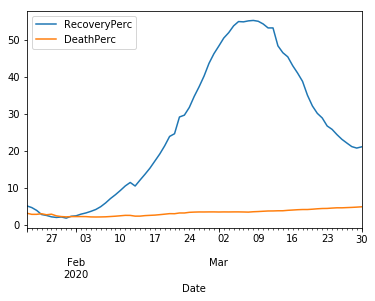

In [16]:
outbreakOverall['ActivePerc'] = outbreakOverall.Active * 100.0 / outbreakOverall.Confirmed
outbreakOverall['RecoveryPerc'] = outbreakOverall.Recovered * 100.0 / outbreakOverall.Confirmed
outbreakOverall['DeathPerc'] = outbreakOverall.Deaths * 100.0 / outbreakOverall.Confirmed

outbreakOverall.plot(x='Date',y=['RecoveryPerc', 'DeathPerc'],kind='line')

As can be seen from the above chart, the number of people Recovered from COVID-19 started increasing exponentially since Feb 13th. The trend started to decline early March as the number of cases started to increase exponentially. So, the overall recovery percent started to come down.

## Speed of COVID-19 outbreak and recovery
Let's try and analyze how fast is the disease spreading and how fast the people are recovering!


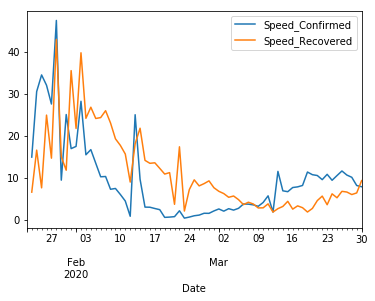

In [17]:
# Compute the speed of spread, recovery and death
outbreakOverall['Speed_Confirmed'] = outbreakOverall.New_Confirmed * 100.0 / outbreakOverall.Confirmed
outbreakOverall['Speed_Recovered'] = outbreakOverall.New_Recovered * 100.0 / outbreakOverall.Recovered
outbreakOverall['Speed_Deaths'] = outbreakOverall.New_Deaths * 100.0 / outbreakOverall.Deaths

outbreakOverall.plot(x='Date',y=['Speed_Confirmed','Speed_Recovered'],kind='line')

The COVID-19 was spreading at close to 50% each day at the end of Jan. **Since Jan 31st, the speed of recovery has overtaken the speed with which the disease was spreading.** 

Now that we are hopeful that the infected people are recovering faster, let's try and analyze the outbreak of the disease by each country.

In [18]:
outbreakByCountry = outbreak.groupby(['Date','Country'])['Confirmed','Deaths','Recovered'].sum()
outbreakByCountry.reset_index(inplace=True)

latestByCountry = outbreakByCountry[outbreakByCountry.Date == max(outbreakByCountry.Date)].sort_values('Confirmed',ascending=False)

latestByCountry['ConfirmedPerc'] = latestByCountry.Confirmed * 100/ latestByCountry.Confirmed.sum()
latestByCountry.head(10)

,Date,Country,Confirmed,Deaths,Recovered,ConfirmedPerc
5321,2020-03-30,US,161807.0,2978.0,5644.0,20.681779
5235,2020-03-30,Italy,101739.0,11591.0,14620.0,13.004033
5305,2020-03-30,Spain,87956.0,7716.0,16780.0,11.242323
5187,2020-03-30,China,81478.0,3304.0,75790.0,10.414321
5215,2020-03-30,Germany,66885.0,645.0,13500.0,8.549079
5211,2020-03-30,France,45170.0,3030.0,7964.0,5.773520
5231,2020-03-30,Iran,41495.0,2757.0,13911.0,5.303790
5320,2020-03-30,UK,22453.0,1411.0,171.0,2.869888
5310,2020-03-30,Switzerland,15922.0,359.0,1823.0,2.035111
5168,2020-03-30,Belgium,11899.0,513.0,1527.0,1.520901


As on March 9th, China had the largest impact with 71% Confirmed amongst over world with Italy(8%), South Korea(6.5%) and Iran(6.3%) following. 

# Outbreak in US

Here are the top 10 US states with COVID-19 outbeak.

In [19]:
states = {
        'AK': 'Alaska',
        'AL': 'Alabama',
        'AR': 'Arkansas',
        'AS': 'American Samoa',
        'AZ': 'Arizona',
        'CA': 'California',
        'CO': 'Colorado',
        'CT': 'Connecticut',
        'DC': 'District of Columbia',
        'DE': 'Delaware',
        'FL': 'Florida',
        'GA': 'Georgia',
        'GU': 'Guam',
        'HI': 'Hawaii',
        'IA': 'Iowa',
        'ID': 'Idaho',
        'IL': 'Illinois',
        'IN': 'Indiana',
        'KS': 'Kansas',
        'KY': 'Kentucky',
        'LA': 'Louisiana',
        'MA': 'Massachusetts',
        'MD': 'Maryland',
        'ME': 'Maine',
        'MI': 'Michigan',
        'MN': 'Minnesota',
        'MO': 'Missouri',
        'MP': 'Northern Mariana Islands',
        'MS': 'Mississippi',
        'MT': 'Montana',
        'NA': 'National',
        'NC': 'North Carolina',
        'ND': 'North Dakota',
        'NE': 'Nebraska',
        'NH': 'New Hampshire',
        'NJ': 'New Jersey',
        'NM': 'New Mexico',
        'NV': 'Nevada',
        'NY': 'New York',
        'OH': 'Ohio',
        'OK': 'Oklahoma',
        'OR': 'Oregon',
        'PA': 'Pennsylvania',
        'PR': 'Puerto Rico',
        'RI': 'Rhode Island',
        'SC': 'South Carolina',
        'SD': 'South Dakota',
        'TN': 'Tennessee',
        'TX': 'Texas',
        'UT': 'Utah',
        'VA': 'Virginia',
        'VI': 'Virgin Islands',
        'VT': 'Vermont',
        'WA': 'Washington',
        'WI': 'Wisconsin',
        'WV': 'West Virginia',
        'WY': 'Wyoming'
}

statesRev = dict(zip(states.values(), states.keys()))

US = outbreak[outbreak.Country == 'US']
US.State = US.State.str.split(',').str[-1].str.strip()
US = US[~US['State'].isin(['Diamond Princess', 'Grand Princess'])]
US['StateCode'] = US.State.apply(lambda x: statesRev[x] if x in statesRev.keys() else x)
US['State'] = US.StateCode.apply(lambda x: states[x] if x in states.keys() else x)
US = US.groupby(['Date','State','StateCode'])['Confirmed','Deaths','Recovered'].sum()
US.reset_index(inplace=True)
latestUS = US[US.Date == max(US.Date)]
latestUS.sort_values('Confirmed',ascending=False)[['Date','StateCode','Confirmed','Deaths']].head(10).style.background_gradient(cmap='Reds')

,Date,StateCode,Confirmed,Deaths
1626,2020-03-30 00:00:00,NY,66663,1218
1624,2020-03-30 00:00:00,NJ,16636,198
1596,2020-03-30 00:00:00,CA,7138,146
1616,2020-03-30 00:00:00,MI,6498,184
1615,2020-03-30 00:00:00,MA,5752,56
1602,2020-03-30 00:00:00,FL,5473,63
1607,2020-03-30 00:00:00,IL,5056,73
1645,2020-03-30 00:00:00,WA,4923,205
1633,2020-03-30 00:00:00,PA,4155,50
1612,2020-03-30 00:00:00,LA,4025,185


* The number of confirmed cases in NY shot up from 2K to 12K in just 4 days from 3/17 to 3/24th.
* Washington, California and New Jersey are following in chart who have already taken initiatives on COVID-19 control. 
* ***Michigan, Illinois, Florida, Louisiana, Texas and Massachusetts have shown sudden increase since 3/15.***

Note: Unfortunately, the data is mission for the US states for the whole month of Feb. So, you might see some empty map in the middle. This also makes our above reports for US over the month of Feb unreliable.

Now, let's look at the latest confirmed cases across US states.

In [20]:
fig = px.choropleth(latestUS, locations='StateCode', locationmode="USA-states", color='Confirmed', scope="usa", color_continuous_scale="Sunsetdark", 
                   hover_data = ['State', 'Confirmed', 'Deaths', 'Recovered'], title='COVID-19 Outbreak across US states')
fig.show()

In [21]:
US['DateStr'] = US['Date'].dt.strftime('%m/%d/%Y')
US['size'] = US.Confirmed.pow(0.3)

fig = px.scatter_geo(US, locations='StateCode', locationmode="USA-states", color='Confirmed', scope="usa",
                   size='size', hover_data = ['State', 'Confirmed', 'Deaths', 'Recovered'], title='COVID-19 Outbreak across US states over time'
                   #,projection="natural earth"
                    ,range_color= [0, max(US['Confirmed'])]
                    , animation_frame="DateStr"
                   )
fig.show()

In [22]:
fig = px.line(US, x="Date", y="Confirmed", color='StateCode', title='Confirmed cases in US by state', height=600)
fig.update_layout(xaxis_rangeslider_visible=True)
fig.show()

In [23]:
TopStates = [#'New York',
 'Washington',
 'California',
 'New Jersey',
 'Michigan',
 'Illinois',
 'Florida',
 'Louisiana',
 'Texas',
 'Massachusetts']

USTopStates = US[US.State.isin(TopStates)].sort_values('Confirmed',ascending=False)
fig = px.line(USTopStates, x="Date", y="Confirmed", title='Confirmed cases in US by state', height=600
             ,facet_col='State', facet_col_wrap=4)
fig.update_layout(xaxis_rangeslider_visible=False)
fig.show()

As can be seen in the above charts for the top US states (excluding NY) have started showing sudden surge since 3/15. These states might also go under stay-in home/quarantine situation soon. 

# Growth in US since 100th confirmed case.
Let's get a perspective on how fast did COVID-19 spread in different states. To understand this, let's start the outbreak in each states since the day they reported more than 100 confirmed cases. 

In [24]:
USByCountryPost100 = US.copy()
USByCountryPost100 = USByCountryPost100[USByCountryPost100.Confirmed >= 100]

topStates = USByCountryPost100[USByCountryPost100.Date == max(USByCountryPost100.Date)].sort_values('Confirmed',ascending=False).State.head(5).tolist()
topStates.append('Washington')
#topStates = ['New York','Washington','New Jersey','California']
fig = px.line(USByCountryPost100[USByCountryPost100.State.isin(topStates)], y='Confirmed',color='State',height=800,title='Outbreak in top 5 states compared with Washington')
fig.update_layout(xaxis_rangeslider_visible=False, yaxis_type='log')
fig.show()

Washington had the first reported case of COVID-19 in the US on Jan 22nd. However, the outbreak in Washington was contained due to the initiatives taken by major companies like Microsoft, Amazon and others initiating WFH in early stages and King County Governor instituting early guidelines on safety protocols. On the otherhand, NY and NJ exploded with the outbreak uncontrollably is still on the rise.